In [7]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os

In [2]:
if 'google.colab' in str(get_ipython()): # running in colab
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/revisiting_crossval_RNAfolding/'
else:
    DATA_PATH = '/home/lbugnon/shared_insync/revisiting_crossval_RNAfolding/'

## Ordendanando archivos 
*NO CORRER ESTA SECCION*
- Esta parte la dejo de referencia, ya deje los csvs limpios
- filtro todo para que queden secuencias de longitud < 512, quedan los bkp cualquier cosa, la idea es que el dataset, particiones y predicciones tengan los mismos ids

In [ ]:
!pip install git+https://github.com/lbugnon/sincfold_utils 

Dataset

In [48]:
dataset = pd.read_csv(f"{DATA_PATH}data/archiveII_220808.csv", index_col="id")
print(dataset.shape, dataset.len.max(), dataset.len.min())
dataset = dataset[dataset.len < 512]
dataset = dataset[["sequence", "len", "structure", "base_pairs"]]
print(dataset.shape, dataset.len.max(), dataset.len.min())
dataset.to_csv(f"{DATA_PATH}data/archiveII_250808.csv")
dataset.head()

(3975, 10) 2968 28
(3864, 4) 510 28


,sequence,len,structure,base_pairs
id,,,,
5s_Acholeplasma-laidlawii-1,UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACA...,112,((((((((......((((((((....((((((.............)...,"[[1, 111], [2, 110], [3, 109], [4, 108], [5, 1..."
5s_Acidovorax-temperans-1,UGCCUGAUGACCAUAGCAAGUUGGUACCACUCCUUCCCAUCCCGAA...,115,.(((((((((.....((((((((.....((((((...............,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1..."
tmRNA_Stre.gord._TRW-29390_1-349,GGGGUCGUUACGGAUUCGACAGGCAUUAUGAGGCAUAUUUUGCGAC...,349,(((((((............((((((((....(((((((((..((((...,"[[1, 345], [2, 344], [3, 343], [4, 342], [5, 3..."
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,UCCGUUGUGGUCCAACGGCUAGGAUUCGUCGCUUUCACCGACGGGA...,75,(((((((..((((........))))((((((.......)))))).....,"[[1, 71], [2, 70], [3, 69], [4, 68], [5, 67], ..."
srp_List.mono._U15684,UGGGUUGAUGAGCGUGAAGCCUUCGCUCGGUUGGAUUUUUCUUCAU...,279,.(.((((...(.(.((.(.((..(.....)..)).)...(...(.....,"[[2, 276], [4, 274], [5, 273], [6, 272], [7, 2..."


Classical methods

In [42]:
from sincfold_utils.io import dot2bp
for method in ["IPKnot", "LinearFoldV", "LinearPartitionC", "LinearPartitionV", "RNAfold", "RNAstructure"]:
    pred = pd.read_csv(DATA_PATH+f"results/{method}.csv", index_col="id")
    pred = pred.loc[dataset.index]
    if "base_pairs" in pred.columns:
        continue
    if " folding" in pred.columns:
        pred["folding"] = pred[" folding"]
        
    if "dataset_name" in pred.columns:
        pred = pred[pred["dataset_name"]=="archiveII"]    

    pred["base_pairs"] = pred["folding"].apply(dot2bp)
    print(f"Saving {method} with fixed base pairs", pred.shape)
    !mv {DATA_PATH}results/{method}.csv {DATA_PATH}results/bkp_clasical_methods/{method}.csv
    pred[["base_pairs"]].to_csv(f"{DATA_PATH}results/{method}.csv")


Saving IPKnot with fixed base pairs (3864, 3)
Saving LinearFoldV with fixed base pairs (3864, 3)
Saving LinearPartitionC with fixed base pairs (3864, 3)
Saving LinearPartitionV with fixed base pairs (3864, 3)
Saving ProbKnot with fixed base pairs (3864, 4)
Saving RNAfold with fixed base pairs (3864, 3)
Saving RNAstructure with fixed base pairs (3864, 3)


In [76]:
method = "ProbKnot"
pred = pd.read_csv(DATA_PATH+f"results/{method}.csv", index_col="id")
pred = pred.loc[dataset.index]
pred["base_pairs"] = pred.folding    
if "dataset_name" in pred.columns:
    pred = pred[pred["dataset_name"]=="archiveII"]    

!mv {DATA_PATH}results/{method}.csv {DATA_PATH}results/bkp_clasical_methods/{method}.csv
print(f"Saving {method} with fixed base pairs", pred.shape)
pred[["base_pairs"]].to_csv(f"{DATA_PATH}results/{method}.csv")


Saving ProbKnot with fixed base pairs (3864, 4)


Some predictions are missing in some methods, these are filled with an empty prediction to be accountable. Also removing unused colunmns


In [33]:
part_folder = "2_fam_folds"
splits = pd.read_csv(f"{DATA_PATH}data/{part_folder}/ArchiveII_splits_famfold.csv", index_col="id")

for method in ["REDfold"]:
    for fold in sorted(splits.fold_number.unique()):
        split_dataset = splits[(splits.fold_number == fold) & (splits.partition == "test")].index
        pred = pd.read_csv(DATA_PATH+f"results/{part_folder}/{method}/{fold}/pred.csv", index_col="id")
        print(fold, pred.shape)
        pred = pred.loc[split_dataset]
        print(pred.shape)
        
        !mkdir -p {DATA_PATH}results/{part_folder}/{method}/bkp/{fold}/
        !mv {DATA_PATH}results/{part_folder}/{method}/{fold}/pred.csv {DATA_PATH}results/{part_folder}/{method}/bkp/{fold}/pred.csv
        pred[["base_pairs"]].to_csv(f"{DATA_PATH}results/{part_folder}/{method}/{fold}/pred.csv")
        

0 (74, 3)
(74, 3)
1 (462, 3)
(462, 3)
2 (557, 3)
(557, 3)
3 (1283, 3)
(1283, 3)
4 (918, 3)
(918, 3)
5 (35, 3)
(35, 3)
6 (454, 3)
(454, 3)
7 (67, 3)
(66, 3)
8 (15, 3)
(15, 3)


In [12]:
# sincfold files 
path = "/home/lbugnon/shared_insync/revisiting_crossval_RNAfolding/results/3_clustering_folds/sincFold/"
for fold in range(5):
    os.makedirs(f"{path}/{fold}", exist_ok=True)
    !cp {path}raw/results_archiveII_default_cdhit_{fold}/output/pred.csv {path}/{fold}/pred.csv

In [26]:
from sincfold_utils.io import read_ct
# UFold files 
path = "/home/lbugnon/shared_insync/revisiting_crossval_RNAfolding/results/3_clustering_folds/UFold/"
for fold in range(5):
    pred = []
    for f in os.listdir(f"{path}/raw/{fold}"):
        if "ct_file_merge" not in f and f.endswith(".ct"):
            _, bp = read_ct(f"{path}/raw/{fold}/{f}")
            id = os.path.splitext(f)[0]
            pred.append({"id": id, "base_pairs": bp})
    pred = pd.DataFrame(pred).set_index("id")
    os.makedirs(f"{path}/{fold}", exist_ok=True)
    pred.to_csv(f"{path}/{fold}/pred.csv")

In [37]:
# hl partition names 
path = "/home/lbugnon/shared_insync/revisiting_crossval_RNAfolding/data/5_hl_folds/"
for f in os.listdir(path):
    if f.endswith(".csv"):
        name = f.split("_")[-1].split(" ")[0]
    os.system(f"cp '{path}/{f}' {path}/split_{name}.csv")

In [44]:
# Ufold hl partitions
path = "/home/lbugnon/shared_insync/revisiting_crossval_RNAfolding/results/5_hl_folds/UFold/"
pred_path = "/home/lbugnon/predictions_hl_ArchiveII_ufold/"
folds = os.listdir(pred_path)
for fold in folds:
    pred = []
    for f in os.listdir(f"{pred_path}/{fold}"):
        if "ct_file_merge" not in f and f.endswith(".ct"):
            _, bp = read_ct(f"{pred_path}/{fold}/{f}")
            id = os.path.splitext(f)[0]
            pred.append({"id": id, "base_pairs": bp})
    pred = pd.DataFrame(pred).set_index("id")
    os.makedirs(f"{path}/{fold.replace('-fold', '')}", exist_ok=True)
    pred.to_csv(f"{path}/{fold.replace('-fold', '')}/pred.csv")

## Performance

In [3]:
dataset = pd.read_csv(f"{DATA_PATH}data/archiveII_250808.csv", index_col="id")
dataset.head()

,sequence,len,structure,base_pairs
id,,,,
5s_Acholeplasma-laidlawii-1,UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACA...,112,((((((((......((((((((....((((((.............)...,"[[1, 111], [2, 110], [3, 109], [4, 108], [5, 1..."
5s_Acidovorax-temperans-1,UGCCUGAUGACCAUAGCAAGUUGGUACCACUCCUUCCCAUCCCGAA...,115,.(((((((((.....((((((((.....((((((...............,"[[2, 115], [3, 114], [4, 113], [5, 112], [6, 1..."
tmRNA_Stre.gord._TRW-29390_1-349,GGGGUCGUUACGGAUUCGACAGGCAUUAUGAGGCAUAUUUUGCGAC...,349,(((((((............((((((((....(((((((((..((((...,"[[1, 345], [2, 344], [3, 343], [4, 342], [5, 3..."
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,UCCGUUGUGGUCCAACGGCUAGGAUUCGUCGCUUUCACCGACGGGA...,75,(((((((..((((........))))((((((.......)))))).....,"[[1, 71], [2, 70], [3, 69], [4, 68], [5, 67], ..."
srp_List.mono._U15684,UGGGUUGAUGAGCGUGAAGCCUUCGCUCGGUUGGAUUUUUCUUCAU...,279,.(.((((...(.(.((.(.((..(.....)..)).)...(...(.....,"[[2, 276], [4, 274], [5, 273], [6, 272], [7, 2..."


Classical methods are not trained, therefore the score per sequence is the same in all cases

In [4]:
from sincfold_utils.metrics import bp_metrics

classical_methods = ["IPKnot", "LinearFoldV", "LinearPartitionC", "LinearPartitionV", "ProbKnot", "RNAfold", "RNAstructure"] 
trained_methods = ["MxFold2", "REDfold", "UFold", "sincFold"]

# load predictions and compute f1 scores
classical_summary = []
for method in classical_methods:
    print(method, end=" ")
    pred = pd.read_csv(DATA_PATH+f"results/{method}.csv", index_col="id")
    pred["ref"] = dataset.loc[pred.index, "base_pairs"]
    pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
    pred["method"] = method
    pred = pred[["method", "f1", "rec", "pre"]]
    classical_summary.append(pred)
classical_summary = pd.concat(classical_summary)    
classical_summary.head()

IPKnot LinearFoldV LinearPartitionC LinearPartitionV ProbKnot RNAfold RNAstructure 

,method,f1,rec,pre
id,,,,
5s_Acholeplasma-laidlawii-1,IPKnot,0.620690,0.600000,0.642857
5s_Acidovorax-temperans-1,IPKnot,0.911765,0.939394,0.885714
tmRNA_Stre.gord._TRW-29390_1-349,IPKnot,0.500000,0.474747,0.528090
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,IPKnot,0.650000,0.590909,0.722222
srp_List.mono._U15684,IPKnot,0.797468,0.732558,0.875000


### Random k-fold

TODO:
- sincfold running
- ufold running

In [48]:
splits = pd.read_csv(f"{DATA_PATH}data/1_random_kfolds/split.csv", index_col="id")
splits.groupby("fold_number").count()

,partition
fold_number,
0,3864
1,3864
2,3864
3,3864
4,3864


In [10]:
import os

folds = sorted(splits["fold_number"].unique())
summary = []
for fold in folds:
    partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"results/1_random_kfolds/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")
        
        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary.append(pred)
summary = pd.concat(summary)    
summary.head()

0 MxFold2 REDfold 
('UFold', 0) not found, skipping


('sincFold', 0) not found, skipping

1 MxFold2 REDfold 
('UFold', 1) not found, skipping


('sincFold', 1) not found, skipping

2 MxFold2 REDfold 
('UFold', 2) not found, skipping


('sincFold', 2) not found, skipping

3 MxFold2 REDfold 
('UFold', 3) not found, skipping


('sincFold', 3) not found, skipping

4 MxFold2 REDfold 
('UFold', 4) not found, skipping


('sincFold', 4) not found, skipping



,method,fold,f1,rec,pre
id,,,,,
5s_Acidovorax-temperans-1,MxFold2,0,0.939394,0.939394,0.939394
5s_Methanothermobacter-thermautotrophicus-6,MxFold2,0,0.739726,0.750000,0.729730
5s_Saprospira-grandis-1,MxFold2,0,0.969697,0.969697,0.969697
grp1_a.I1.e.P.inouyei.C1.SSU.1506,MxFold2,0,0.649573,0.638655,0.660870
5s_Ralstonia-pickettii-1,MxFold2,0,1.000000,1.000000,1.000000


In [11]:
# add classical methods to kfold summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary = pd.concat([summary, res])
summary.method.unique()        

array(['MxFold2', 'REDfold', 'IPKnot', 'LinearFoldV', 'LinearPartitionC',
       'LinearPartitionV', 'ProbKnot', 'RNAfold', 'RNAstructure'],
      dtype=object)

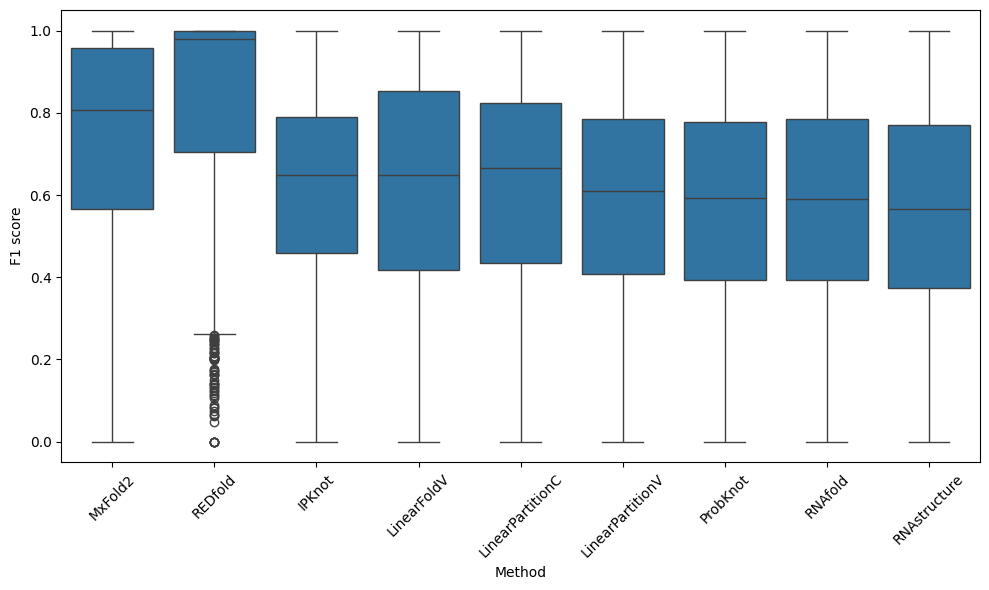

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

# boxplot methods (to improve)
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary, x="method", y="f1")
plt.xticks(rotation=45)
plt.xlabel("Method")
plt.ylabel("F1 score")
plt.tight_layout()


### fam-fold

TODO:
- sincfold running
- ufold running

In [49]:
splits = pd.read_csv(f"{DATA_PATH}data/2_fam_folds/split.csv", index_col="id")
splits.head()

,fold_name,fold_number,partition
id,,,
5s_Acholeplasma-laidlawii-1,grp1,0,train
5s_Acidovorax-temperans-1,grp1,0,train
tmRNA_Stre.gord._TRW-29390_1-349,grp1,0,train
tRNA_tdbR00000055-Schizosaccharomyces_pombe-4896-Glu-3UC,grp1,0,train
srp_List.mono._U15684,grp1,0,train


In [36]:
folds = sorted(splits["fold_number"].unique())
summary = []
for fold in folds:
    partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"results/2_fam_folds/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")
        
        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary.append(pred)
summary = pd.concat(summary)    
summary.head()

0 MxFold2 REDfold 
('UFold', 0) not found, skipping


('sincFold', 0) not found, skipping

1 MxFold2 REDfold 
('UFold', 1) not found, skipping


('sincFold', 1) not found, skipping

2 MxFold2 REDfold 
('UFold', 2) not found, skipping


('sincFold', 2) not found, skipping

3 MxFold2 REDfold 
('UFold', 3) not found, skipping


('sincFold', 3) not found, skipping

4 MxFold2 REDfold 
('UFold', 4) not found, skipping


('sincFold', 4) not found, skipping

5 MxFold2 REDfold 
('UFold', 5) not found, skipping


('sincFold', 5) not found, skipping

6 MxFold2 REDfold 
('UFold', 6) not found, skipping


('sincFold', 6) not found, skipping

7 MxFold2 REDfold 
('UFold', 7) not found, skipping


('sincFold', 7) not found, skipping

8 MxFold2 REDfold 
('UFold', 8) not found, skipping


('sincFold', 8) not found, skipping



,method,fold,f1,rec,pre
id,,,,,
grp1_a.I1.m.M.grisea.B2.ND1,MxFold2,0,0.598639,0.676923,0.536585
grp1_a.I1.e.P.inouyei.C1.SSU.1506,MxFold2,0,0.644068,0.638655,0.649573
grp1_a.I1.e.C.saxonicum.C1.SSU.1506,MxFold2,0,0.483051,0.475000,0.491379
grp1_b.I1.e.M.anisopliae.3.C1.LSU.1921,MxFold2,0,0.681614,0.690909,0.672566
grp1_a.I1.e.G.planctonica.C1.SSU.943,MxFold2,0,0.635379,0.656716,0.615385


In [37]:
# add classical methods to the summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary = pd.concat([summary, res])
summary.method.unique()        

array(['MxFold2', 'REDfold', 'IPKnot', 'LinearFoldV', 'LinearPartitionC',
       'LinearPartitionV', 'ProbKnot', 'RNAfold', 'RNAstructure'],
      dtype=object)

In [40]:
summary.fold

id
grp1_a.I1.m.M.grisea.B2.ND1               0
grp1_a.I1.e.P.inouyei.C1.SSU.1506         0
grp1_a.I1.e.C.saxonicum.C1.SSU.1506       0
grp1_b.I1.e.M.anisopliae.3.C1.LSU.1921    0
grp1_a.I1.e.G.planctonica.C1.SSU.943      0
                                         ..
23s_E.coli_domain3                        8
23s_B.subtilis_domain3                    8
23s_S.aureus_domain4                      8
23s_B.subtilis_domain4                    8
23s_H.pylori_domain4                      8
Name: fold, Length: 34776, dtype: int64

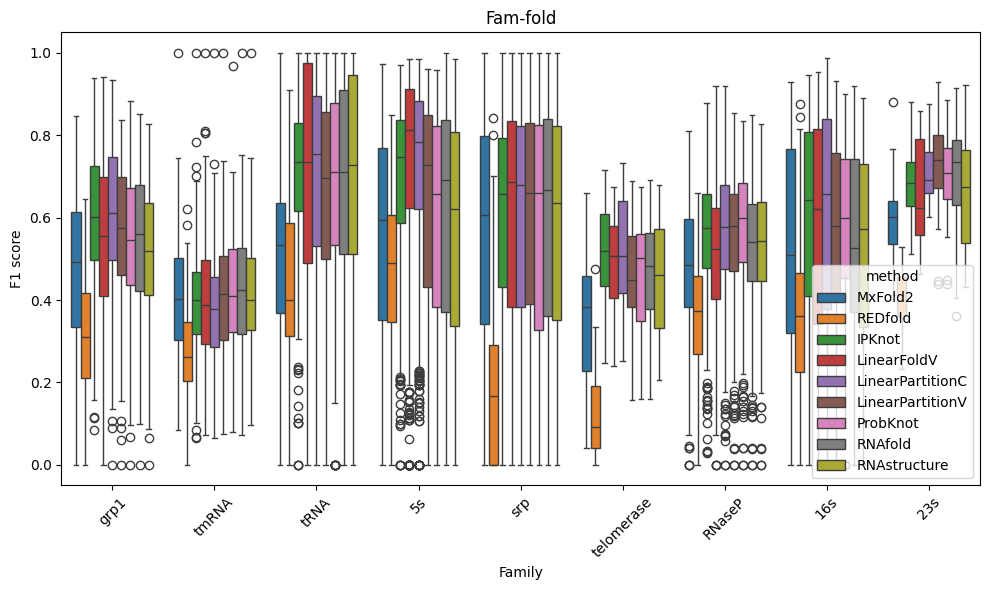

In [46]:
from matplotlib import pyplot as plt
import seaborn as sns

family_name = {n: splits[splits.fold_number==n].iloc[0].fold_name for n in sorted(splits.fold_number.unique())}
summary["family"] = summary.fold.apply(lambda x: family_name[x])

# boxplot methods (to improve)
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary, x="family", y="f1", hue="method")
plt.xticks(rotation=45)
plt.xlabel("Family")
plt.ylabel("F1 score")
plt.title("Fam-fold")
plt.tight_layout()

### Clustering folds

In [27]:
partition_name = "3_clustering_folds"
splits = pd.read_csv(f"{DATA_PATH}data/{partition_name}/split.csv", index_col="id")
splits.head()

,fold_number,partition
id,,
16s_B.burgdorferi_domain4,0,test
RNaseP_T.roseum,0,test
tmRNA_uncu.bact._TRW-45456_1-408,0,test
srp_Picr.torr._AE017261,0,test
tRNA_tdbR00000122-Codium_fragile-3133-Gly-UCC,0,test


In [29]:
folds = sorted(splits["fold_number"].unique())
summary = []
for fold in folds:
    partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"results/{partition_name}/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")
        
        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary.append(pred)
    print()
summary = pd.concat(summary)    
summary.head()

0 MxFold2 REDfold UFold sincFold 
1 MxFold2 REDfold UFold sincFold 
2 MxFold2 REDfold UFold sincFold 
3 MxFold2 REDfold UFold sincFold 
4 MxFold2 REDfold UFold sincFold 


,method,fold,f1,rec,pre
id,,,,,
16s_B.burgdorferi_domain4,MxFold2,0,0.904762,0.863636,0.950000
RNaseP_T.roseum,MxFold2,0,0.455446,0.446602,0.464646
tmRNA_uncu.bact._TRW-45456_1-408,MxFold2,0,0.153110,0.160000,0.146789
srp_Picr.torr._AE017261,MxFold2,0,0.590000,0.614583,0.567308
tRNA_tdbR00000122-Codium_fragile-3133-Gly-UCC,MxFold2,0,0.850000,0.809524,0.894737


In [30]:
# add classical methods to the summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits[(splits["fold_number"] == fold) & (splits["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary = pd.concat([summary, res])
summary.method.unique()        

array(['MxFold2', 'REDfold', 'UFold', 'sincFold', 'IPKnot', 'LinearFoldV',
       'LinearPartitionC', 'LinearPartitionV', 'ProbKnot', 'RNAfold',
       'RNAstructure'], dtype=object)

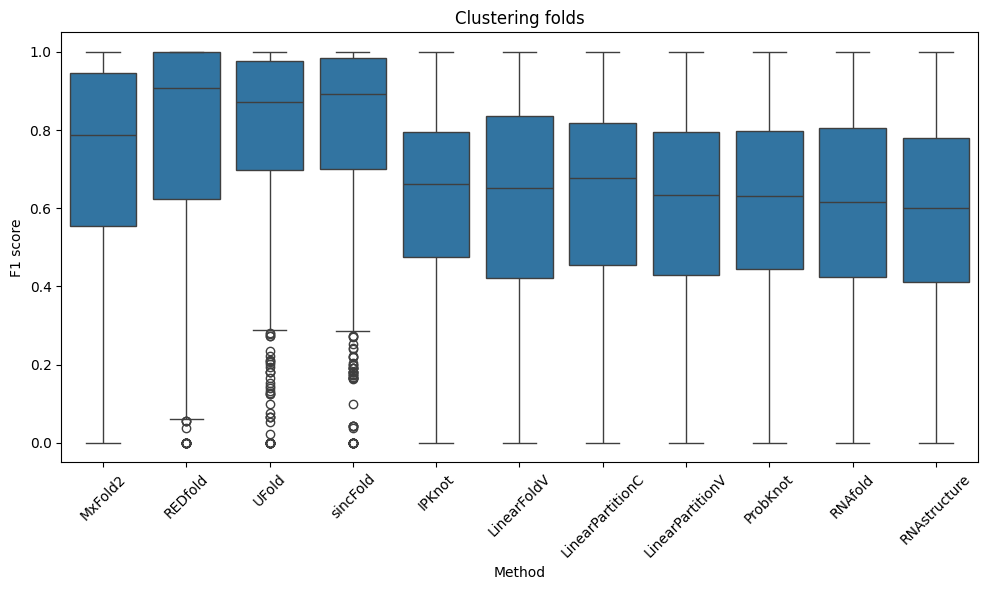

In [31]:
# boxplot methods (to improve)
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary, y="f1", x="method")
plt.xticks(rotation=45)
plt.xlabel("Method")
plt.ylabel("F1 score")
plt.title("Clustering folds")
plt.tight_layout()

### HL folds
- sincFold TODO
- mxfold2 h5 missing?
- split file should be unique

In [52]:
partition_name = "5_hl_folds"
splits = []
for k, f in enumerate(sorted(os.listdir(f"{DATA_PATH}data/{partition_name}/"))):
    df = pd.read_csv(f"{DATA_PATH}data/{partition_name}/{f}", index_col="id")
    df["fold_number"] = k
    df["fold_name"] = f.split("_")[1].split("-")[0]
    splits.append(df)
splits = pd.concat(splits)
splits.head()

,fold_name,fold_number,partition
id,,,
srp_Coxi.burn._AE016828,hl10,0,test
tRNA_tdbR00000052-Aedes_albopictus-7160-Glu-NUC,hl10,0,test
srp_Proc.mari._AE017126,hl10,0,test
srp_Kine.radi._CP000750,hl10,0,test
srp_Phyt.infe._CV911012,hl10,0,test


In [53]:
folds = sorted(splits["fold_name"].unique())
summary = []
for fold in folds:
    partition_set = splits[(splits["fold_name"] == fold) & (splits["partition"] == "test")]
    print(fold, end=" ")
    for method in trained_methods:
        f = DATA_PATH+f"results/{partition_name}/{method}/{fold}/pred.csv"
        if not os.path.exists(f):
            print(f"\n{method, fold} not found, skipping\n")
            continue
        print(method, end=" ")
        
        pred = pd.read_csv(f, index_col="id")
        pred["ref"] = dataset.loc[partition_set.index, "base_pairs"]
        pred[["f1", "rec", "pre"]] = pred.apply(lambda x: bp_metrics(json.loads(x["ref"]), json.loads(x["base_pairs"])), axis=1, result_type="expand")
        pred["method"] = method
        pred["fold"] = fold
        pred = pred[["method", "fold", "f1", "rec", "pre"]]
        summary.append(pred)
    print()
summary = pd.concat(summary)    
summary.head()

hl10 MxFold2 REDfold UFold 
('sincFold', 'hl10') not found, skipping


hl15 MxFold2 REDfold UFold 
('sincFold', 'hl15') not found, skipping


hl20 MxFold2 REDfold UFold 
('sincFold', 'hl20') not found, skipping


hl25 MxFold2 REDfold UFold 
('sincFold', 'hl25') not found, skipping


hl30 MxFold2 REDfold UFold 
('sincFold', 'hl30') not found, skipping


hl35 MxFold2 REDfold UFold 
('sincFold', 'hl35') not found, skipping


hl40 MxFold2 REDfold UFold 
('sincFold', 'hl40') not found, skipping


hl45 MxFold2 REDfold UFold 
('sincFold', 'hl45') not found, skipping


hl5 
('MxFold2', 'hl5') not found, skipping

REDfold UFold 
('sincFold', 'hl5') not found, skipping


hl50 MxFold2 REDfold UFold 
('sincFold', 'hl50') not found, skipping


hl55 MxFold2 REDfold UFold 
('sincFold', 'hl55') not found, skipping


hl60 MxFold2 REDfold UFold 
('sincFold', 'hl60') not found, skipping


hl65 MxFold2 REDfold UFold 
('sincFold', 'hl65') not found, skipping


hl70 MxFold2 REDfold UFold 
('sincFold', 'hl70

,method,fold,f1,rec,pre
id,,,,,
srp_Coxi.burn._AE016828,MxFold2,hl10,0.000000,0.000000,0.000000
tRNA_tdbR00000052-Aedes_albopictus-7160-Glu-NUC,MxFold2,hl10,0.631579,0.600000,0.666667
srp_Proc.mari._AE017126,MxFold2,hl10,0.909091,0.833333,1.000000
srp_Kine.radi._CP000750,MxFold2,hl10,0.000000,0.000000,0.000000
srp_Phyt.infe._CV911012,MxFold2,hl10,0.000000,0.000000,0.000000


In [54]:
# add classical methods to the summary
for method in classical_methods:
    for fold in folds:
        partition_set = splits[(splits["fold_name"] == fold) & (splits["partition"] == "test")]
        res = classical_summary.loc[partition_set.index]
        res = res[res["method"] == method]
        res["fold"] = fold
        summary = pd.concat([summary, res])
summary.method.unique()        

array(['MxFold2', 'REDfold', 'UFold', 'IPKnot', 'LinearFoldV',
       'LinearPartitionC', 'LinearPartitionV', 'ProbKnot', 'RNAfold',
       'RNAstructure'], dtype=object)

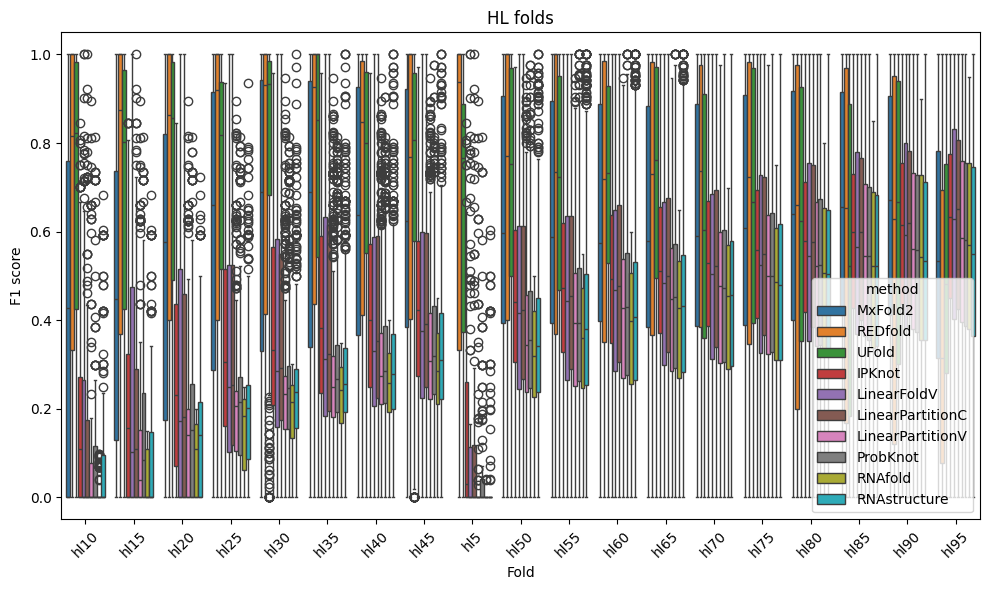

In [55]:
# boxplot methods (to improve)
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary, y="f1", x="fold", hue="method")
plt.xticks(rotation=45)
plt.xlabel("Fold")
plt.ylabel("F1 score")
plt.title("HL folds")
plt.tight_layout()